# Modeling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

import scipy.stats as stats
import pylab as py

In [2]:
sumo_df = pd.read_csv('../data/sumo_premodel_df.csv')

In [3]:
sumo_df.head()

,id,sumodb_id,nsk_id,ring_name,current_rank,height,weight,total_wins,total_losses,total_matches,rank_group,age,win_rate,debut_year,tenure,ichimon
0,7522,10438,0,Hakushuzan,Retired,0.0,0.0,27,36,63,4,0,42.86,1954,5,Unaffilliated
1,2973,5772,0,Wakahokkai Gentaro,Retired,0.0,0.0,146,160,306,4,81,47.71,1959,7,Unaffilliated
2,6428,6679,0,Kakuryuasahi,Retired,178.5,111.0,26,23,49,4,53,53.06,1987,1,Isegahama
3,3683,381,0,Katsumayama Shuichi,Retired,177.0,113.5,223,211,434,4,46,51.38,1994,11,Nishonoseki
4,6560,7299,0,Otsuru,Retired,186.0,77.0,78,73,151,4,57,51.66,1983,4,Nishonoseki


## Table of Contents
- [Age Modeling](#Age-Modeling)
- [Predict Rikishi Ages](#Predict-Rikishi-Ages)
- [Exploring Height and Weight Modeling](#Exploring-Height-and-Weight-Modeling)
- [Weight Modeling](#Weight-Modeling)

## Age Modeliing

#### 13% of the dataset does not have valid ages.  The goal is to use a model to predict the ages instead of imputing a mean or mode as that would be less accurate.  Some of the rikishi in this set have passed on, but I will keep their projected ages for the sake of modeling.

In [4]:
sumo_df['age'].value_counts(normalize = True) * 100

age
0      12.909350
48      2.218794
47      2.100142
51      1.934029
46      1.886569
         ...    
102     0.071191
15      0.035596
103     0.023730
104     0.011865
105     0.011865
Name: proportion, Length: 92, dtype: float64

#### Using linear regression to predict age based on rikishi's debut year looks like a good method.  They have a linear relationship according to the plot below, but it also shows points that are missing age data.

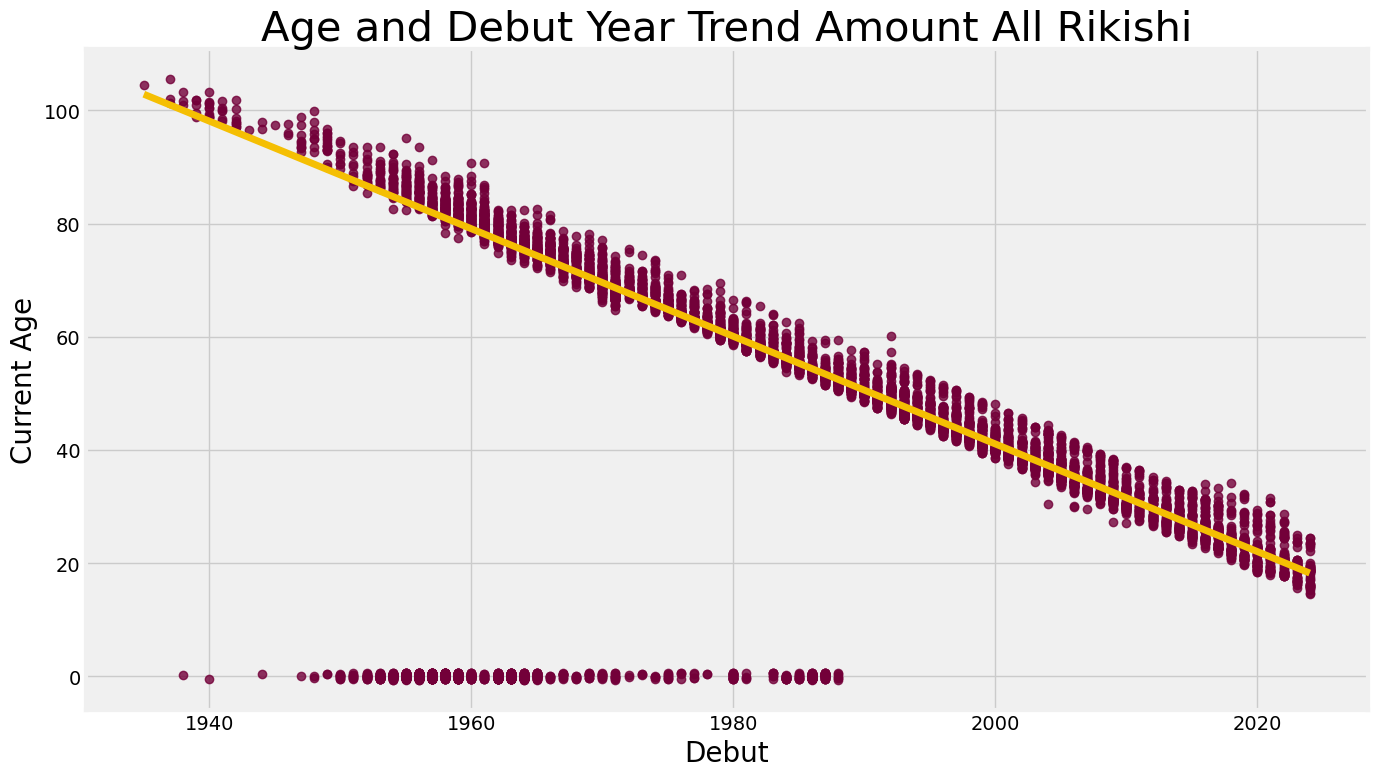

In [5]:
plt.figure(figsize = (14, 8))
plt.style.use('fivethirtyeight')


plt.title('Age and Debut Year Trend Amount All Rikishi',
         size = 30)

plt.xlabel('Debut', size = 20)

sns.regplot(data = sumo_df,
            x = 'debut_year',
            y = 'age',
            ci = None,
            y_jitter = .60,
            scatter_kws={'color':'xkcd:merlot'},
            line_kws={'lw': 5, 'color':'xkcd:golden'},
            robust = True)

plt.xlabel('Debut', size = 20)
plt.ylabel('Current Age', size = 20)

plt.tight_layout()
# plt.savefig('../plots/active_rikisi_age_vs_debut.png', dpi = 192);

### Linear Regression - Using Debut Year to Predict Age

#### Make two tables, one where every rikishi has a valid age and one where every rikishi's age equals 0.

In [6]:
age_sumo_df = sumo_df[sumo_df['age'] != 0]
no_age_sumo_df  = sumo_df[sumo_df['age'] == 0].copy()

#### Use the age_sumo_df to model with. Once the model is created, predict ages on the no_age_sumo_df data.

In [7]:
X = age_sumo_df[['debut_year']]
y = age_sumo_df['age']

In [8]:
# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 24)

#### Basline Model and Trying out LinearRegression!

In [9]:
#Basline model as the mean
y_bar = np.mean(y_test)

#### Baseline model is 18.6 years.

In [10]:
print(f'Null Mean Squared Error: {np.mean((y - y_bar)**2)}')
print(f'Null Root Mean Squared Error: {np.sqrt(np.mean((y - y_bar)**2))}')

Null Mean Squared Error: 344.229656467863
Null Root Mean Squared Error: 18.553427081481818


In [11]:
lr = LinearRegression()

In [12]:
lr.fit(X_train, y_train)

LinearRegression()

#### Linear Regression Metrics for Age Prediction 

In [13]:
# R2 values for training and testing scores.  This looks decent and not overfit.
print(f'Training R-Squared Score: {lr.score(X_train, y_train)}')
print(f'Testing R-Squred Score: {lr.score(X_test, y_test)}')

Training R-Squared Score: 0.9884139906711619
Testing R-Squred Score: 0.9885906228455991


In [14]:
scores = cross_val_score(lr, X_train, y_train, cv=5)

# Step 4: Print the cross-validation scores
print("Train Cross-Validation Scores: ", scores)
print("Train Mean Cross-Validation Score: ", scores.mean())

Train Cross-Validation Scores:  [0.98775606 0.98916852 0.98887724 0.98775485 0.9884644 ]
Train Mean Cross-Validation Score:  0.9884042144713325


In [15]:
scores = cross_val_score(lr, X_test, y_test, cv=5)

# Step 4: Print the cross-validation scores
print("Test Cross-Validation Scores: ", scores)
print("Test Mean Cross-Validation Score: ", scores.mean())

Test Cross-Validation Scores:  [0.99136288 0.98735673 0.98866642 0.98898951 0.98607711]
Test Mean Cross-Validation Score:  0.9884905321618304


#### Apply model to test data and create age residuals variable

In [16]:
# Predictions on training data and calculating residuals
y_pred = lr.predict(X_test)
resids = y_test - y_pred

#### A RMSE of 2.0 is a big improvement over 18.6

In [17]:
print(f'Mean Squared Error: {metrics.mean_squared_error(y_test, y_pred)}')
print(f'Root Mean Squared Error: {metrics.mean_squared_error(y_test, y_pred, squared = False)}')

Mean Squared Error: 3.985316710474552
Root Mean Squared Error: 1.9963258026871646


#### LINE Assumptions
- L: There is a linear relationship betweeen a rikishi's age and their debut year as visualized in the above plot.
- I: There could be a break here because I am not sure if the average age for a new rikishi has changed over time.
- N: The residuals are <b>not</b> normal.  The plot is right skewed, which indicates that most rikishi debut at younger ages.
- E: There is no equal variance of residuals

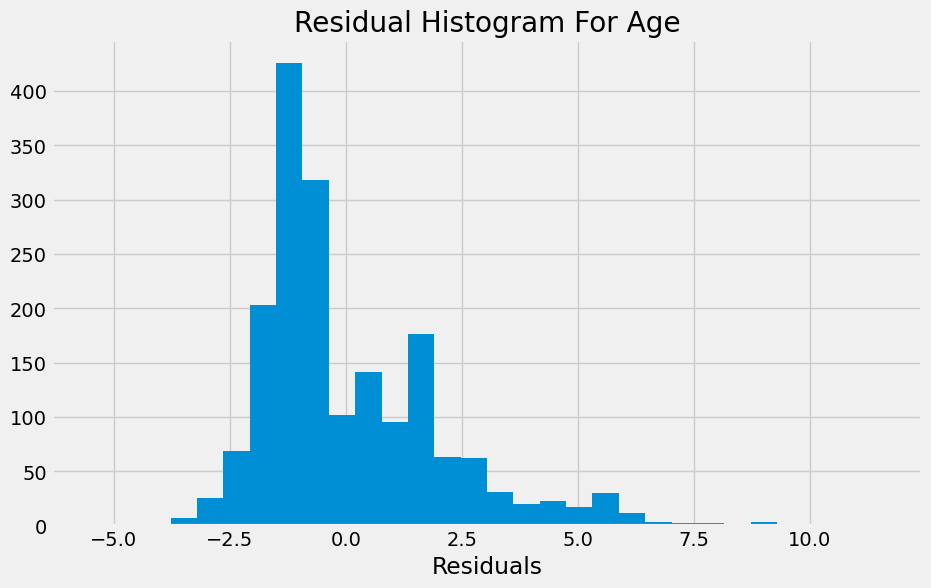

In [18]:
plt.figure(figsize=(10, 6))
plt.hist(resids, bins = 30)
plt.xlabel('Residuals')
plt.title('Residual Histogram For Age');

<Figure size 1000x600 with 0 Axes>

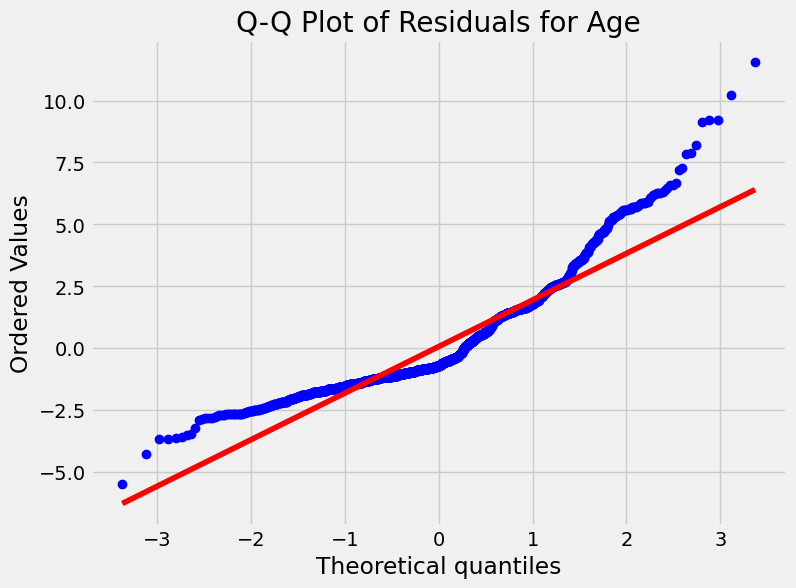

In [19]:
plt.figure(figsize=(10,6))
plt.figure(figsize=(8, 6))
stats.probplot(resids, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals for Age')
plt.show()

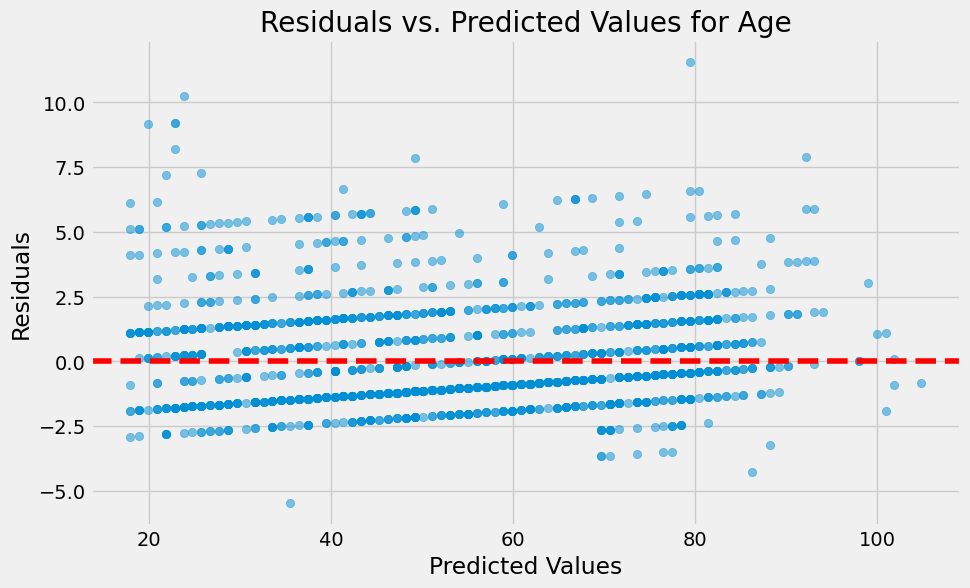

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, resids, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values for Age')
plt.axhline(y=0, color='r', linestyle='--')

### Random Forest Model

#### Trying out Random Forest as an alternate model since linear model doesn't pass LINE assumption.  Both do equally well.

In [21]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [22]:
scores = cross_val_score(rf, X_train, y_train, cv=5)

# Step 4: Print the cross-validation scores
print("Train Cross-Validation Scores: ", scores)
print("Mean Train Cross-Validation Score: ", scores.mean())

Train Cross-Validation Scores:  [0.98847071 0.98973362 0.98974396 0.98842379 0.98934707]
Mean Train Cross-Validation Score:  0.9891438311438179


In [23]:
scores = cross_val_score(rf, X_test, y_test, cv=5)

# Step 4: Print the cross-validation scores
print("Test Cross-Validation Scores: ", scores)
print("Mean Test Cross-Validation Score: ", scores.mean())

Test Cross-Validation Scores:  [0.99085871 0.98709541 0.98864316 0.9891459  0.9862487 ]
Mean Test Cross-Validation Score:  0.9883983770167232


## Predict Rikishi Ages

In [24]:
# Drop the age column from the no_age_sumo_df.  A column will be added that includes the predicted ages to replace it.
no_age_sumo_df.drop(columns = ['age'], inplace = True)

In [25]:
# Create a new dataframe with the debut years of all rikishi from the no_age_sumo_df.  This column will be the 'X' value to predict age.
unseen_age_df = no_age_sumo_df[['debut_year']]

In [26]:
no_age_sumo_df['age_predicted'] = lr.predict(unseen_age_df).astype(int)

### Age Coefficient
#### As the year increases, the age decreases by about one year

In [27]:
age_coefficients = lr.coef_
print('Age Coefficient: ', age_coefficients)

Age Coefficient:  [-0.97665727]


### Add Predicted Ages to Sumo Dataframe

In [28]:
# This works because the indexing between the two dataframes remained the same.  The mask is TRUE
# when 'age' is 0.  If true, the value will be updated with the 'age_predicted' value at the same index
# in no_age_sumo_df.

mask = sumo_df['age'] == 0
sumo_df.loc[mask, 'age'] = no_age_sumo_df.loc[mask, 'age_predicted']

## Exploring Height and Weight Modeling

#### It looks like for all missing height and weight values, they are missing as pairs. 1839 observations total are missing this information."

In [29]:
sumo_df['weight'].value_counts()

weight
0.0      1839
100.0     153
110.0     135
75.0      126
105.0     120
         ... 
135.1       1
156.9       1
162.2       1
148.4       1
109.6       1
Name: count, Length: 672, dtype: int64

In [30]:
sumo_df['height'].value_counts()

height
0.0      1839
173.0     425
175.0     384
178.0     369
174.0     367
         ... 
170.8       1
186.2       1
173.1       1
186.3       1
160.0       1
Name: count, Length: 211, dtype: int64

In [31]:
# check how many rows where height and weight are both zero and see if it matches 1839
sumo_df[(sumo_df['height'] == 0) & (sumo_df['weight'] == 0)].shape[0]


1839

#### All except one rikishi with missing height and weight data are retired.

In [32]:
# Create a table that only contains observations where height and weight data are missing

misssinghw_df = sumo_df[(sumo_df['height'] == 0) & (sumo_df['weight'] == 0)]
misssinghw_df['current_rank'].value_counts()

current_rank
Retired     1838
Sandanme       1
Name: count, dtype: int64

#### Create a mask for rows where height and weight are missing so they can be dropped and complete data can be explored.

In [33]:
heightweight_mask = (sumo_df['height'] == 0) & (sumo_df['weight'] == 0)

In [34]:
# Create a database where observations missing height and weight data are dropped

heightweight_df = sumo_df[~heightweight_mask]

In [35]:
heightweight_df.head()

,id,sumodb_id,nsk_id,ring_name,current_rank,height,weight,total_wins,total_losses,total_matches,rank_group,age,win_rate,debut_year,tenure,ichimon
2,6428,6679,0,Kakuryuasahi,Retired,178.5,111.0,26,23,49,4,53,53.06,1987,1,Isegahama
3,3683,381,0,Katsumayama Shuichi,Retired,177.0,113.5,223,211,434,4,46,51.38,1994,11,Nishonoseki
4,6560,7299,0,Otsuru,Retired,186.0,77.0,78,73,151,4,57,51.66,1983,4,Nishonoseki
5,2954,4235,0,Banryunada Kenzo,Retired,173.0,83.0,162,167,329,4,87,49.24,1953,12,Dewanoumi
7,6531,7381,0,Onakajima,Retired,176.0,95.0,14,21,35,4,55,40.00,1985,1,Unaffilliated


#### Make a heatmap to observe which features are correlated with height and weight

Text(0.5, 1.0, 'Sumo Data Heatmap')

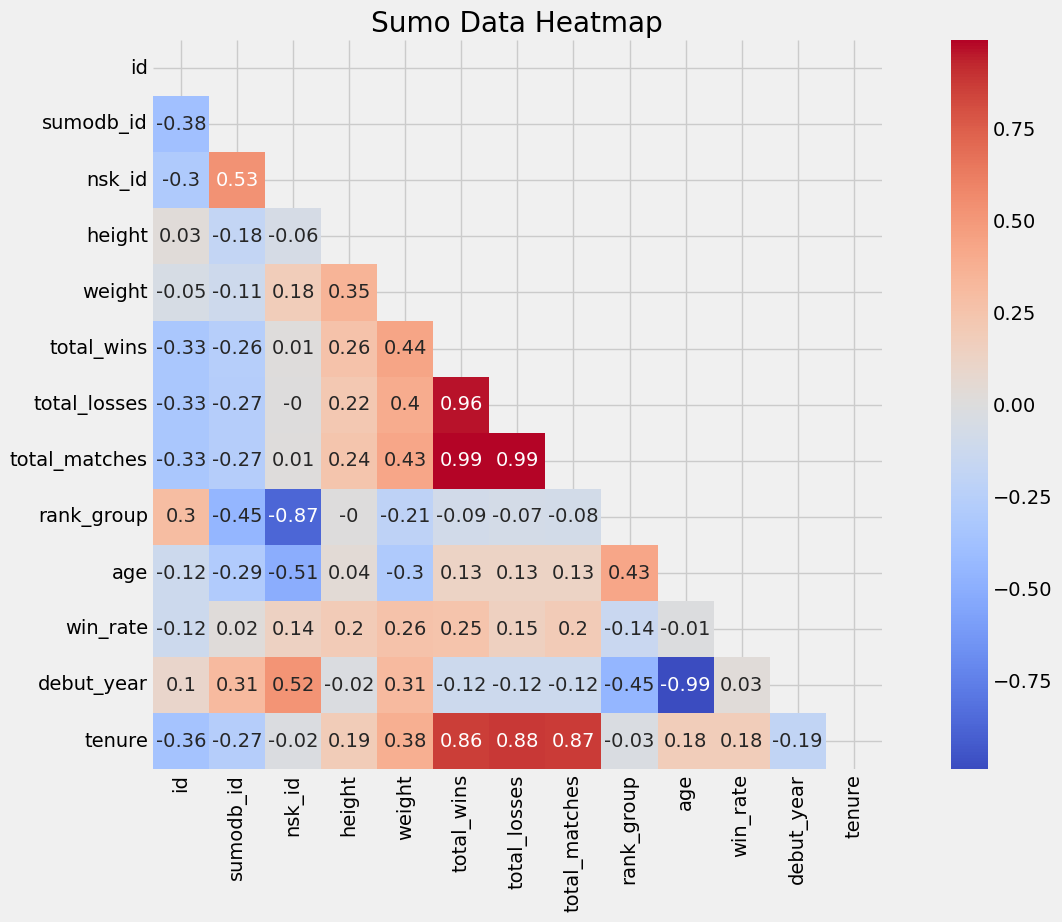

In [36]:
# Create a heatmap to observe correlations between height, weight, and other features.
plt.figure(figsize = (16,9))

corr = round(heightweight_df.corr(numeric_only=True), 2)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,
            square = True,
            annot = True,
            cmap = 'coolwarm',
            mask = mask);

plt.title('Sumo Data Heatmap')

#### I will try to model weight first as there looks to be more features correlated to it such as:
- Tenure
- Debut Year
- Age
- Rank Group
- Total Matches

#### Once I have weights, I can use that along with other features to predict height.  Weight happens to be the highest correlated feature for height.

## Weight Modeling

#### Linear Regression - Using a variety of features to predict weight.

In [37]:
# Create X features and y value to predict

X = heightweight_df[['tenure','debut_year', 'age', 'rank_group', 'total_matches',]]
y = heightweight_df['weight']

In [38]:
# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 24)

In [39]:
#Basline model as the mean
y_bar = np.mean(y_test)

#### Baseline model is 25.4 kg or 58.2 pounds

In [40]:
print(f'Null Mean Squared Error: {np.mean((y - y_bar)**2)}')
print(f'Null Root Mean Squared Error: {np.sqrt(np.mean((y - y_bar)**2))}')

Null Mean Squared Error: 697.235703285068
Null Root Mean Squared Error: 26.405221136833298


In [41]:
hw_lr = LinearRegression()

In [42]:
hw_lr.fit(X_train, y_train)

LinearRegression()

#### Linear Regression Metrics For Weight Prediction

In [43]:
print(f'Training R-Squared Score: {hw_lr.score(X_train, y_train)}')
print(f'Testing R-Squred Score: {hw_lr.score(X_test, y_test)}')

Training R-Squared Score: 0.33730910364665656
Testing R-Squred Score: 0.32257045809705454


In [44]:
scores = cross_val_score(lr, X_train, y_train, cv=5)

# Step 4: Print the cross-validation scores
print("Train Cross-Validation Scores: ", scores)
print("Train Mean Cross-Validation Score: ", scores.mean())

Train Cross-Validation Scores:  [0.30671434 0.31523503 0.3434125  0.34031774 0.36226803]
Train Mean Cross-Validation Score:  0.3335895299967759


In [45]:
scores = cross_val_score(lr, X_test, y_test, cv=5)

# Step 4: Print the cross-validation scores
print("Test Cross-Validation Scores: ", scores)
print("Test Mean Cross-Validation Score: ", scores.mean())

Test Cross-Validation Scores:  [0.33741897 0.31315758 0.326036   0.34302319 0.27568153]
Test Mean Cross-Validation Score:  0.3190634533280084


#### Apply model to test data and create age residuals variable

In [46]:
# Predictions on training data and calculating residuals
y_pred = hw_lr.predict(X_test)
resids = y_test - y_pred

#### A RMSE of 21.6 kg is a slight improvement over 25.4 kg (58.2 poundds vs 47.6)

In [47]:
print(f'Mean Squared Error: {metrics.mean_squared_error(y_test, y_pred)}')
print(f'Root Mean Squared Error: {metrics.mean_squared_error(y_test, y_pred, squared = False)}')

Mean Squared Error: 467.82073613051904
Root Mean Squared Error: 21.6291640182999


#### Line Assumptions

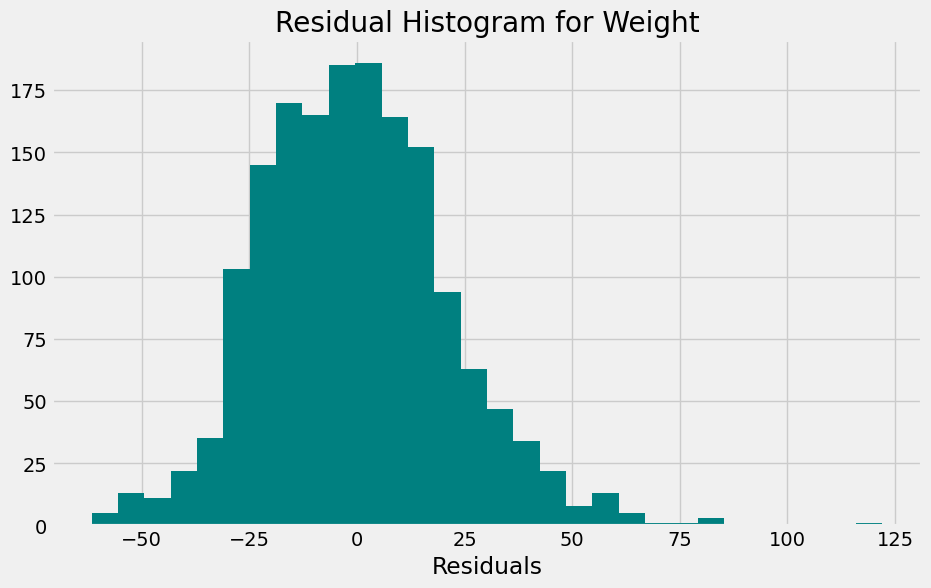

In [48]:
plt.figure(figsize=(10, 6))
plt.hist(resids, bins = 30, color = 'teal')
plt.xlabel('Residuals')
plt.title('Residual Histogram for Weight');

<Figure size 1000x600 with 0 Axes>

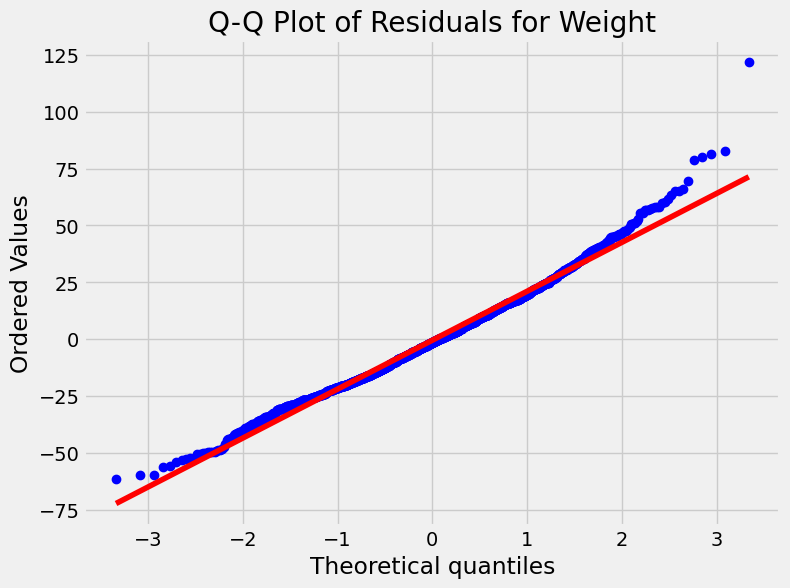

In [49]:
plt.figure(figsize=(10,6))
plt.figure(figsize=(8, 6))
stats.probplot(resids, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals for Weight')
plt.show()

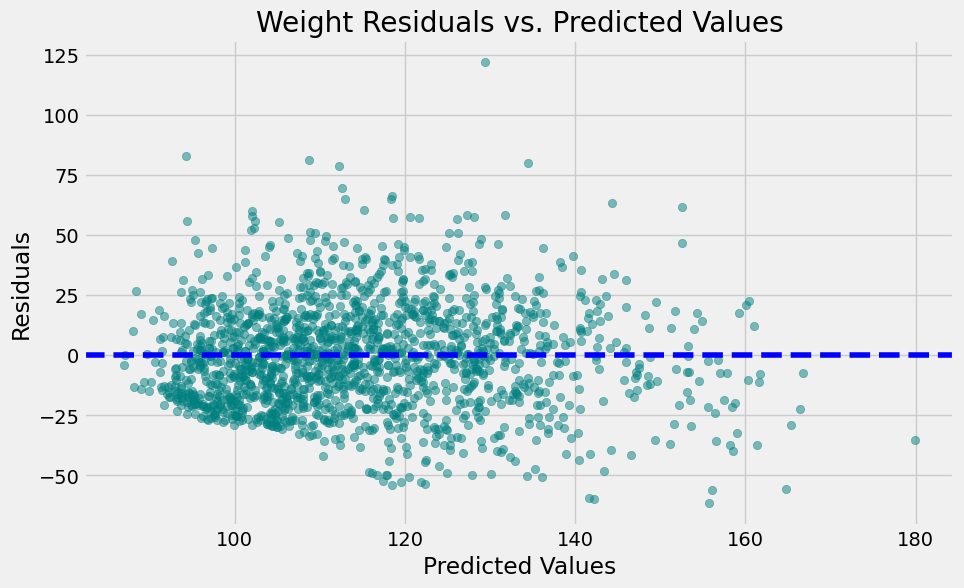

In [51]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, resids, alpha=0.5, color = 'teal')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Weight Residuals vs. Predicted Values')
plt.axhline(y=0, color='b', linestyle='--')

### Random Forest Model

####  Check if Random Forest can perform better than Linear Regression

In [52]:
weight_rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [54]:
scores = cross_val_score(rf, X_train, y_train, cv=5)

# Step 4: Print the weightcross-validation scores
print("Train Cross-Validation Scores: ", scores)
print("Mean Train Cross-Validation Score: ", scores.mean())

Train Cross-Validation Scores:  [0.23540918 0.23662109 0.24451834 0.25120335 0.32087821]
Mean Train Cross-Validation Score:  0.2577260336394822


In [55]:
scores = cross_val_score(rf, X_test, y_test, cv=5)

# Step 4: Print the cross-validation scores
print("Test Cross-Validation Scores: ", scores)
print("Mean Test Cross-Validation Score: ", scores.mean())

Test Cross-Validation Scores:  [0.27353047 0.28460406 0.25177436 0.28962328 0.29711371]
Mean Test Cross-Validation Score:  0.27932917747723557
